In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
from statsmodels.api import OLS, add_constant
from sklearn.linear_model import LinearRegression
from scipy.stats import f


In [ ]:
#datos
data_raw = pd.read_excel("datos_transporte.xlsx", sheet_name='datos ln')

In [ ]:
#variables
mes = data_raw['mes'] 
pax = data_raw['pax']
tiempo = np.arange(1, 40)

In [ ]:
#df
datos = pd.DataFrame({'tiempo': tiempo, 'mes': mes, 'pax': pax})

In [ ]:
#detección automatica del punto de quiembre
signal = datos['pax'].values.reshape(-1, 1)
model = "l2" #modelo de segmentación (mco)
bkpt_finder = rpt.Binseg(model=model).fit(signal)
breakpoints = bkpt_finder.predict(n_bkps=1)
print(f"Punto de quiebre detectado automáticamente: {breakpoints}")

Punto de quiebre detectado automáticamente: [25, 39]


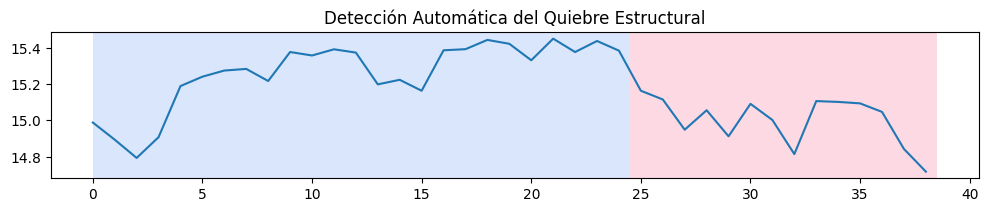

In [ ]:
#graph
rpt.display(signal, breakpoints)
plt.title("Detección Automática del Quiebre Estructural")
plt.show()

In [ ]:
#chow
def chow_test(data, split_point):
    X = add_constant(data['pax'])
    y = data['tiempo']
    
    X1 = X[:split_point] #antes del punto de quiebre.
    y1 = y[:split_point] #antes del punto de quiebre.
    X2 = X[split_point:] #después del punto de quiebre.
    y2 = y[split_point:] #después del punto de quiebre.
    
    model_full = OLS(y, X).fit() #con todos los datos.
    model_1 = OLS(y1, X1).fit() #con datos antes del punto de quiebre.
    model_2 = OLS(y2, X2).fit() #con datos después del punto de quiebre.
    
    RSS_full = sum(model_full.resid ** 2) 
    RSS_1 = sum(model_1.resid ** 2) 
    RSS_2 = sum(model_2.resid ** 2) 
    
    k = X.shape[1]  #variables explicativas.
    n1, n2 = len(y1), len(y2)
    
    F_stat = ((RSS_full - (RSS_1 + RSS_2)) / k) / ((RSS_1 + RSS_2) / (n1 + n2 - 2 * k)) #estadístico
    p_value = 1 - f.cdf(F_stat, k, n1 + n2 - 2 * k) #p-value
    
    return F_stat, p_value

punto_quiebre = 25
chow_stat, p_value = chow_test(datos, punto_quiebre)
print(f"Estadístico de Chow: {chow_stat}, p-valor: {p_value}")

Estadístico de Chow: 94.76061580573682, p-valor: 7.438494264988549e-15


Text(0, 0.5, 'mes')

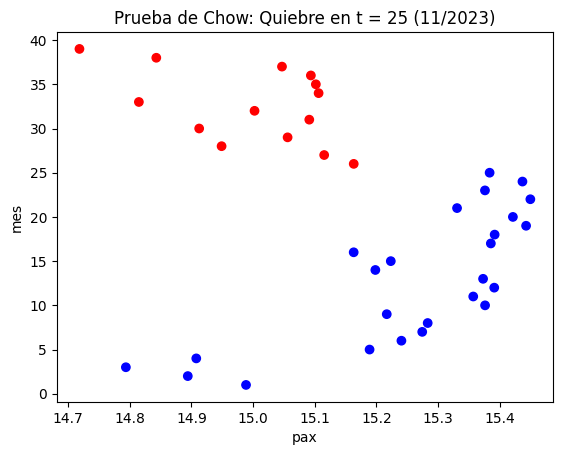

In [ ]:
#graph chow
plt.scatter(datos['pax'], datos['tiempo'], c=['blue' if t <= punto_quiebre else 'red' for t in tiempo]) 
plt.title("Prueba de Chow: Quiebre en t = 25 (11/2023)")
plt.xlabel("pax")
plt.ylabel("mes")

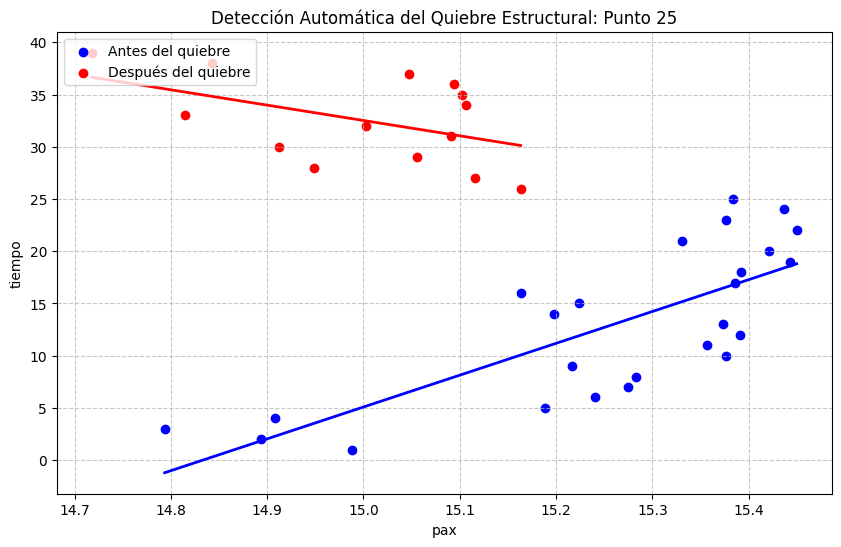

In [ ]:
#resultados de la detección automática
datos_antes = datos[datos['tiempo'] <= punto_quiebre]
datos_despues = datos[datos['tiempo'] > punto_quiebre]

X_antes = datos_antes['pax'].values.reshape(-1, 1)
y_antes = datos_antes['tiempo'].values
X_despues = datos_despues['pax'].values.reshape(-1, 1)
y_despues = datos_despues['tiempo'].values

modelo_antes = LinearRegression().fit(X_antes, y_antes)
modelo_despues = LinearRegression().fit(X_despues, y_despues)

plt.figure(figsize=(10, 6))
plt.scatter(datos_antes['pax'], datos_antes['tiempo'], color='blue', label='Antes del quiebre')
plt.scatter(datos_despues['pax'], datos_despues['tiempo'], color='red', label='Después del quiebre')

pax_range_antes = np.linspace(min(datos_antes['pax']), max(datos_antes['pax']), 100).reshape(-1, 1)
pax_range_despues = np.linspace(min(datos_despues['pax']), max(datos_despues['pax']), 100).reshape(-1, 1)

plt.plot(pax_range_antes, modelo_antes.predict(pax_range_antes), color='blue', linewidth=2)
plt.plot(pax_range_despues, modelo_despues.predict(pax_range_despues), color='red', linewidth=2)

plt.title(f"Detección Automática del Quiebre Estructural: Punto {punto_quiebre}")
plt.xlabel("pax")
plt.ylabel("tiempo")
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()